In [1]:
from tanke_dodge import TankDodge
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

pygame 2.6.1 (SDL 2.28.4, Python 3.13.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


/home/anky/Github/RL/.venv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super().__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, x):
        logits = self.actor(x)
        value = self.critic(x)
        return logits, value

In [4]:
class PPOBuffer:
    def __init__(self):
        self.states = []
        self.actions = []
        self.logprobs = []
        self.rewards = []
        self.dones = []
        self.values = []

    def clear(self):
        self.states.clear()
        self.actions.clear()
        self.logprobs.clear()
        self.rewards.clear()
        self.dones.clear()
        self.values.clear()

In [5]:
def compute_gae(rewards, values, dones, gamma=0.99, lam=0.95, last_value=0):
    advantages = []
    gae = 0
    values = values + [last_value]
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + gamma * values[i+1] * (1 - dones[i]) - values[i]
        gae = delta + gamma * lam * (1 - dones[i]) * gae
        advantages.insert(0, gae)
    return advantages

def ppo_update(model, optimizer, buffer, last_value=0, clip_epsilon=0.2, epochs=4, batch_size=64, gamma=0.99, lam=0.95, entropy_coef=0.01, value_coef=0.5):
    states = torch.tensor(np.array(buffer.states), dtype=torch.float32, device=device)
    actions = torch.tensor(buffer.actions, dtype=torch.long, device=device)
    old_logprobs = torch.tensor(buffer.logprobs, dtype=torch.float32, device=device)
    rewards = buffer.rewards
    dones = buffer.dones
    values = buffer.values

    # Compute advantages and returns
    values_for_gae = values + [last_value]
    advantages = compute_gae(rewards, values, dones, gamma, lam) if last_value == 0 else compute_gae(rewards, values, dones, gamma, lam)
    if last_value != 0:
        advantages = compute_gae(rewards, values + [last_value], dones, gamma, lam)
        returns = torch.tensor(advantages, dtype=torch.float32, device=device) + torch.tensor(values, dtype=torch.float32, device=device)
    else:
        returns = torch.tensor(advantages, dtype=torch.float32, device=device) + torch.tensor(values, dtype=torch.float32, device=device)
    advantages = torch.tensor(advantages, dtype=torch.float32, device=device)
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    dataset_size = len(states)
    for _ in range(epochs):
        idxs = np.arange(dataset_size)
        np.random.shuffle(idxs)
        for start in range(0, dataset_size, batch_size):
            end = start + batch_size
            batch_idx = idxs[start:end]
            batch_states = states[batch_idx]
            batch_actions = actions[batch_idx]
            batch_old_logprobs = old_logprobs[batch_idx]
            batch_returns = returns[batch_idx]
            batch_advantages = advantages[batch_idx]

            logits, values_pred = model(batch_states)
            dist = torch.distributions.Categorical(logits=logits)
            logprobs = dist.log_prob(batch_actions)
            entropy = dist.entropy().mean()

            ratios = torch.exp(logprobs - batch_old_logprobs)
            surr1 = ratios * batch_advantages
            surr2 = torch.clamp(ratios, 1 - clip_epsilon, 1 + clip_epsilon) * batch_advantages
            actor_loss = -torch.min(surr1, surr2).mean()
            critic_loss = (batch_returns - values_pred.squeeze()).pow(2).mean()
            loss = actor_loss + value_coef * critic_loss - entropy_coef * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [6]:
env = TankDodge(num_enemies=3)
state_dim = 2 + 2 * env.num_enemies
action_dim = 4

model = ActorCritic(state_dim, action_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0003)

max_episodes = 5000
max_steps = 1000
update_timestep = 2048
gamma = 0.99
lam = 0.95

rewards_history = []
buffer = PPOBuffer()
timestep = 0

for episode in range(max_episodes):
    state = env.reset()
    ep_reward = 0
    for step in range(max_steps):
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        logits, value = model(state_tensor)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample().item()
        logprob = dist.log_prob(torch.tensor(action, device=device)).item()

        next_state, reward, done, _ = env.step(action)
        buffer.states.append(state)
        buffer.actions.append(action)
        buffer.logprobs.append(logprob)
        buffer.rewards.append(reward)
        buffer.dones.append(done)
        buffer.values.append(value.item())

        state = next_state
        ep_reward += reward
        timestep += 1

        if timestep % update_timestep == 0:
            with torch.no_grad():
                last_state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                _, last_value = model(last_state_tensor)
            # Update PPO, pass last_value
            ppo_update(model, optimizer, buffer, last_value=last_value.item(), gamma=gamma, lam=lam)
            buffer.clear()

        if done:
            break

    rewards_history.append(ep_reward)
    print(f"Episode {episode+1} | Reward: {ep_reward}")

Episode 1 | Reward: 146
Episode 2 | Reward: 159
Episode 3 | Reward: 142
Episode 4 | Reward: 156
Episode 5 | Reward: 163
Episode 6 | Reward: 152
Episode 7 | Reward: 193
Episode 8 | Reward: 135
Episode 9 | Reward: 184
Episode 10 | Reward: 187
Episode 11 | Reward: 161
Episode 12 | Reward: 102
Episode 13 | Reward: 146
Episode 14 | Reward: 128
Episode 15 | Reward: 240
Episode 16 | Reward: 149
Episode 17 | Reward: 152
Episode 18 | Reward: 82
Episode 19 | Reward: 212
Episode 20 | Reward: 161
Episode 21 | Reward: 174
Episode 22 | Reward: 187
Episode 23 | Reward: 137
Episode 24 | Reward: 69
Episode 25 | Reward: 187
Episode 26 | Reward: 141
Episode 27 | Reward: 138
Episode 28 | Reward: 119
Episode 29 | Reward: 99
Episode 30 | Reward: 150
Episode 31 | Reward: 192
Episode 32 | Reward: 91
Episode 33 | Reward: 122
Episode 34 | Reward: 110
Episode 35 | Reward: 244
Episode 36 | Reward: 159
Episode 37 | Reward: 109
Episode 38 | Reward: 98
Episode 39 | Reward: 138
Episode 40 | Reward: 103
Episode 41 | R

In [7]:
torch.save(model.state_dict(), "saved_weights/ppo_tank_dodge.pth")

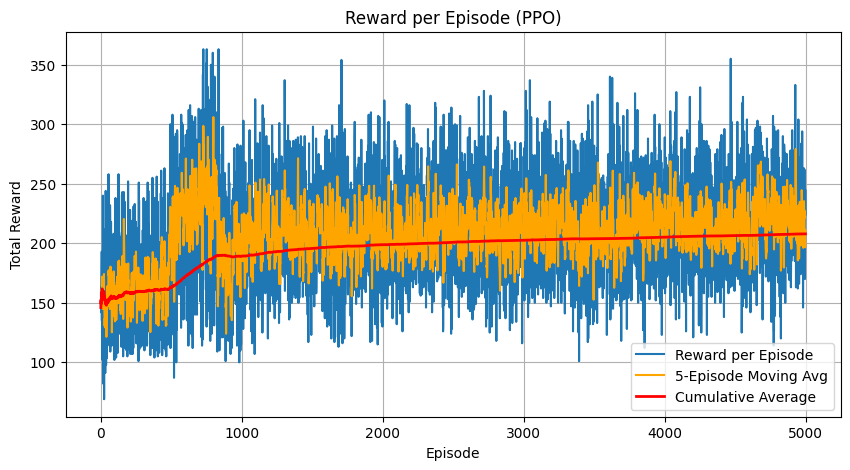

In [8]:
plt.figure(figsize=(10,5))
plt.plot(rewards_history, label="Reward per Episode")
if len(rewards_history) >= 5:
    avg5 = np.convolve(rewards_history, np.ones(5)/5, mode='valid')
    plt.plot(range(4, len(rewards_history)), avg5, label="5-Episode Moving Avg", color='orange')
global_mean = np.cumsum(rewards_history) / (np.arange(len(rewards_history)) + 1)
plt.plot(global_mean, label="Cumulative Average", color='red', linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Reward per Episode (PPO)")
plt.grid()
plt.legend()
plt.show()